# 证券数据集下使用LSTM模型预测A股走势

作者信息：[edencfc](https://github.com/edencfc)

更新日期：2022 年 12 月 8 日

摘要: 本示例将会演示如何使用飞桨完成多变量输入的时序数据预测任务。**这个任务以一只A股的价格走势作为示例，将会构建一个LSTM网络预测其未来的涨跌情况。**

--

## 1. 简要介绍

本示例将实现在[Tushare](https://tushare.pro/)上基于股票的历史走势信息，对未来一个交易日的涨跌的趋势进行预测。

## 2. 环境设置

本示例基于PaddlePaddle 2.4.0 编写，如果你的环境不是本版本，请先参考官网安装 PaddlePaddle 2.4.0。

In [42]:
!pip install dnutils==0.3.12

In [43]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_finance import candlestick2_ochl
from dnutils import ifnone
from sklearn.preprocessing import MinMaxScaler

# 导入 paddle
import paddle
import paddle.nn.functional as F
print(paddle.__version__)

import warnings
warnings.filterwarnings("ignore")

## 3. 数据集

### 3.1 数据下载与查看
Tushare是一个免费、开源的python财经数据接口包。主要实现对股票等金融数据从数据采集、清洗加工到数据存储的过程。Tushare返回的绝大部分的数据格式都是pandas DataFrame类型，非常易于使用。其优点请访问[官网](https://tushare.pro/)。

In [ ]:
# 安装tushare
!pip install tushare -i https://pypi.tuna.tsinghua.edu.cn/simple/ --trusted-host pypi.tuna.tsinghua.edu.cn

下载一只股票的k线数据，这里取sz.002648 2020年以后的数据。

In [45]:
import tushare as ts
df=ts.get_hist_data('002648')

在我们获取的历史A股K线数据中，各参数名称含义如下：

- date：日期
- open：开盘价
- high：最高价
- close：收盘价
- low：最低价
- volume：成交量
- price_change：价格变动
- p_change：涨跌幅
- ma5：5日均价
- ma10：10日均价
- ma20:20日均价
- v_ma5:5日均量
- v_ma10:10日均量
- v_ma20:20日均量

In [46]:
float_type = ['open', 'high', 'close', 'low', 'volume', 'price_change', 'p_change',
       'ma5', 'ma10', 'ma20', 'v_ma5', 'v_ma10', 'v_ma20', 'turnover']

for item in float_type:
    df[item] = df[item].astype('float')

df['buy_flag'] = 10

### 3.2 时间序列数据的展示
绘制股票K线图

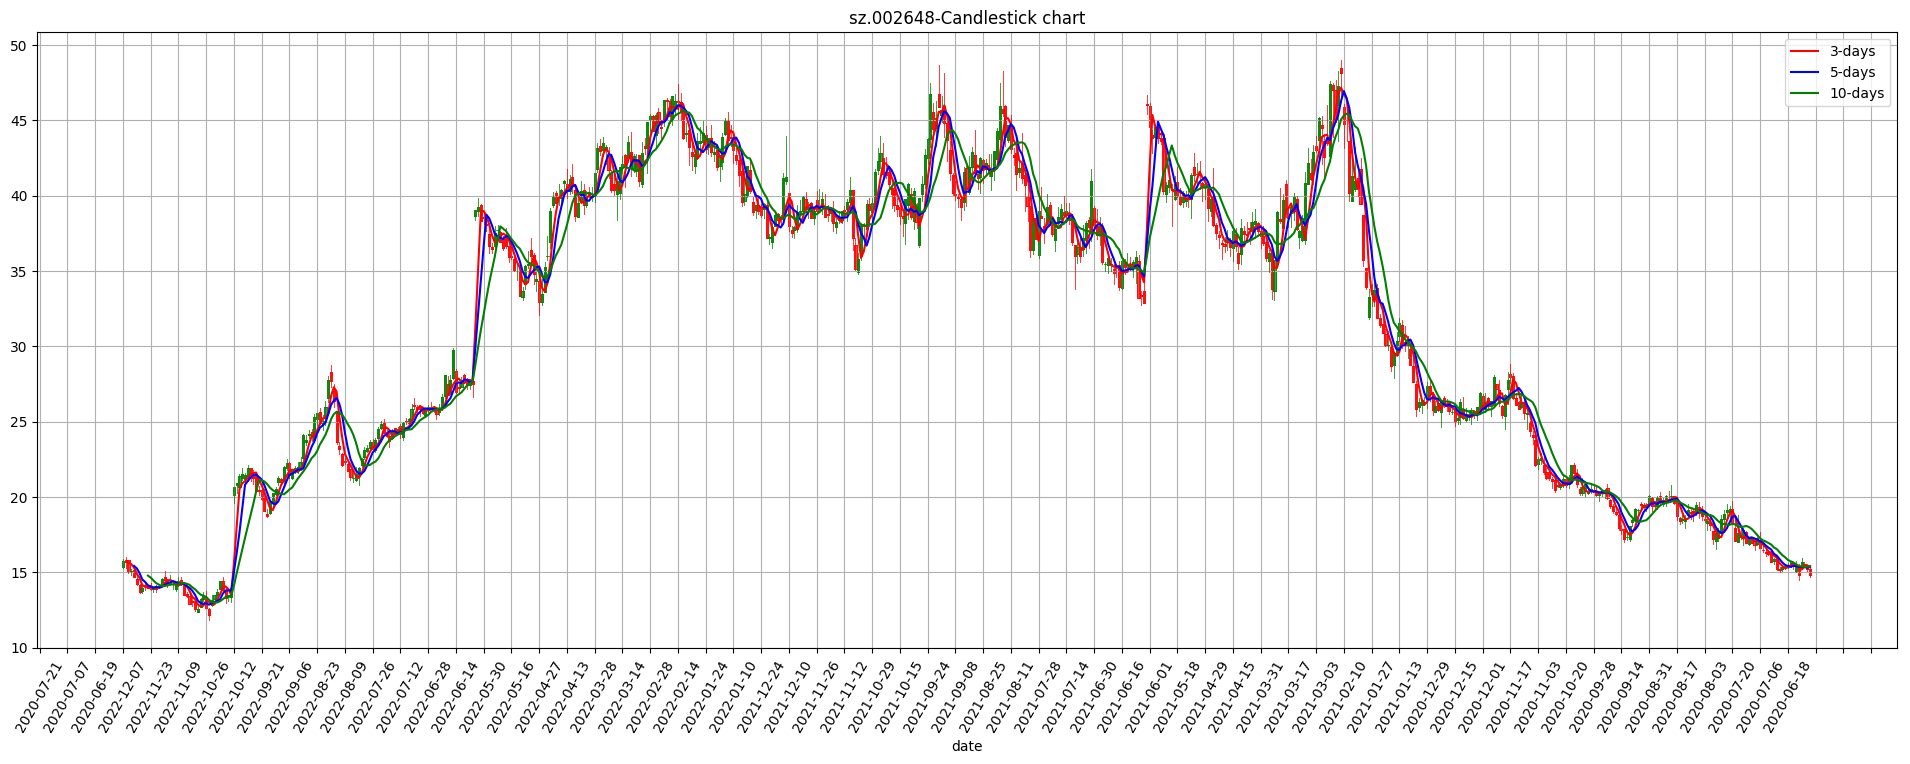

In [47]:
fig, ax = plt.subplots(figsize=(24, 8))
xmajorLocator = MultipleLocator(10)     # 将x轴主刻度设置为5的倍数
ax.xaxis.set_major_locator(xmajorLocator)
# 调用方法绘制K线图
candlestick2_ochl(ax = ax, opens=df["open"].values,closes=df["close"].values, highs=df["high"].values, lows=df["low"].values,width=0.75, colorup='red', colordown='green')
# 如下是绘制3种均线
df['close'].rolling(window=3).mean().plot(color="red",label='3-days')
df['close'].rolling(window=5).mean().plot(color="blue",label='5-days')
df['close'].rolling(window=10).mean().plot(color="green",label='10-days')
plt.legend(loc='best')     # 绘制图例
ax.grid(True)     # 带网格线
plt.title("sz.002648-Candlestick chart")
plt.setp(plt.gca().get_xticklabels(), rotation=60)
plt.show()

### 3.3 数据集的处理
用 LSTM 预测价格显示是不合理的，因为价格的波动非常不可控，所以我们退而求其次，预测股票的走势，即涨还是跌。

但是怎么量化股票的涨跌是个问题，这里我们用未来数天的平均股价表示股票的起伏。

In [17]:
#未来n天移动平均，包含今天
def MA_next(df, date_idx, price_type, n): 
    return df[price_type][date_idx:date_idx+n].mean()

假设短期2天，中期6天，长期15天。如果未来15天平均价格大于未来6天平均价格大于未来2天平均价格，我们就可认为未来15天的股市走势很好。
这里还要求有3%的涨幅，能一定程度上减少标签频繁波动。

`2` 含义为买入，`0` 含义为卖出，`1` 为默认值

In [18]:
s_time = 2
m_time = 6
l_time = 15

for i in range(len(df)-l_time):
    if MA_next(df,i,'close',l_time)>MA_next(df,i,'close',m_time)*1.03>MA_next(df,i,'close',s_time)*1.03:
        df.loc[i, 'buy_flag'] = 2
    elif MA_next(df,i,'close',s_time)>MA_next(df,i,'close',m_time):
        df.loc[i, 'buy_flag'] = 0
    else:
        df.loc[i, 'buy_flag'] = 1

通过使用函数`add_datepart`，能计算当前日期的年、月、日、一周第几天、周数、月初月末、一年当中的第几天等信息。本项目用该函数扩展日期特征。

In [20]:
def make_date(df, date_field):
    "Make sure `df[date_field]` is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)

In [21]:
def add_datepart(df, field_name, prefix=None, drop=True, time=False):
    "Helper function that adds columns relevant to a date in the column `field_name` of `df`."
    make_date(df, field_name)
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    # Pandas removed `dt.week` in v1.1.10
    week = field.dt.isocalendar().week.astype(field.dt.day.dtype) if hasattr(field.dt, 'isocalendar') else field.dt.week
    for n in attr: df[prefix + n] = getattr(field.dt, n.lower()) if n != 'Week' else week
    mask = ~field.isna()
    df[prefix + 'Elapsed'] = np.where(mask,field.values.astype(np.int64) // 10 ** 9,np.nan)
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

接下来我们为数据生成序列，用前`seq_length`天的信息作为输入序列，后1天的股市起伏`buy_flag`作为标签

In [39]:
# 增加日期特征
add_datepart(df, "date", drop=False)
seq_length = 30
train_df = df[seq_length:-seq_length]
# 丢掉不重要的特征
train_df = train_df.drop(['date','Is_month_end', 'Is_month_start', 'Is_quarter_end',
                          'Is_quarter_start', 'Is_year_end', 'Is_year_start','Dayofyear'],axis=1)
train_df

In [24]:
# 数据清洗，填充nan值
train_df= train_df.fillna(0)

### 3.4 构造训练集与验证集

In [25]:
def sliding_windows(data, label, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = label[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [26]:
# 数据归一化
y_scaler = MinMaxScaler()
x_scaler = MinMaxScaler()

X = train_df.drop(['buy_flag'],axis=1).values
X = x_scaler.fit_transform(X)
Y = train_df['buy_flag']
Y = np.array(Y).reshape(-1,1)

x, y = sliding_windows(X, Y, seq_length)

y_train,y_test = y[:int(y.shape[0]*0.8)],y[int(y.shape[0]*0.8):]
x_train,x_test = x[:int(x.shape[0]*0.8)],x[int(x.shape[0]*0.8):]

In [27]:
class MyDataset(paddle.io.Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, x, y):
        """
        步骤二：实现 __init__ 函数，初始化数据集，将样本和标签映射到列表中
        """
        super(MyDataset, self).__init__()
        self.data = paddle.to_tensor(x.transpose(1,0,2), dtype='float32')
        self.label = paddle.to_tensor(y, dtype='float32')

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__函数，定义指定index时如何获取数据，并返回单条数据（样本数据、对应的标签）
        """
        data = self.data[index]
        label = self.label[index]
        return data, label

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return len(self.data)

# 实例化数据集
train_dataset = MyDataset(x_train, y_train)
eval_dataset = MyDataset(x_test, y_test)

In [28]:
# 查看数据样本
x_train[0][8]

array([0.03253615, 0.02447745, 0.0220117 , 0.03665988, 0.34586643,
       0.54482759, 0.503     , 0.13475177, 0.18967122, 0.10060887,
       0.3064197 , 0.35039425, 0.55347378, 0.22823529, 1.        ,
       0.81818182, 0.76923077, 0.43333333, 1.        , 0.98547215])

In [29]:
x_train.shape

(414, 30, 20)

In [30]:
y_train.shape

(414, 1)

## 4. 模型组网

本项目构造了简单的LSTM层，具体步骤如下：

1. 连接LSTM层，从时间步的维度进行时序建模。
2. 通过全连接层输出预测值。
3. 模型的损失函数选择为均方误差，优化方法采用adam优化器。

In [31]:
class LSTM(paddle.nn.Layer):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length       
        self.lstm = paddle.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        # self.relu = paddle.nn.ReLU()
        self.fc = paddle.nn.Linear(hidden_size, num_classes)
        # self.relu = paddle.nn.ReLU()
        # self.head = paddle.nn.Linear(int(hidden_size/2), out_features=num_classes)
        

    def forward(self, x):
        x, (h, c)=self.lstm(x)
        # print(h)
        # x = x[:,-1,:]
        h = h[-1]
        x = self.fc(h) 
        # x = self.head(x)
        # print(out)
        return x

In [32]:
# 打印网络结构
model = LSTM(128,18,300,1)
paddle.summary(model, (30,796,18))

W1208 00:57:53.667572   264 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W1208 00:57:53.671578   264 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


-----------------------------------------------------------------------------------------------------
 Layer (type)       Input Shape                       Output Shape                      Param #    
    LSTM-2        [[30, 796, 18]]    [[30, 796, 300], [[1, 30, 300], [1, 30, 300]]]     384,000    
   Linear-1         [[30, 300]]                        [30, 128]                        38,528     
Total params: 422,528
Trainable params: 422,528
Non-trainable params: 0
-----------------------------------------------------------------------------------------------------
Input size (MB): 1.64
Forward/backward pass size (MB): 54.82
Params size (MB): 1.61
Estimated Total Size (MB): 58.08
-----------------------------------------------------------------------------------------------------



{'total_params': 422528, 'trainable_params': 422528}

## 5. 模型训练

使用模型网络结构和数据集进行模型训练。

在高层API中，可以用 paddle.Model 完成模型封装后，然后通过 Model.prepare 进行训练前的配置准备工作，包括设置优化算法、Loss 计算方法、评价指标计算方法；接着通过Model.fit接口来启动训练。

在训练过程中，需要根据模型训练过程中loss，打印loss下降曲线来调参。为了保存训练时每个batch的loss信息，需要自己定义Callback函数，完成模型训练时loss信息的记录。

In [33]:
# 自定义Callback 需要继承基类 Callback
class LossCallback(paddle.callbacks.Callback):

    def __init__(self):
        self.losses = []
        
    def on_train_begin(self, logs={}):
        # 在fit前 初始化losses，用于保存每个batch的loss结果
        self.losses = []
    
    def on_train_batch_end(self, step, logs={}):
        # 每个batch训练完成后调用，把当前loss添加到losses中
        self.losses.append(logs.get('loss'))
loss_log = LossCallback()

In [40]:
from paddle.static import InputSpec
# 参数设置
num_epochs = 15
learning_rate = 1e-3

input_size = train_df.shape[1]-1 # 输入的变量指标数量
hidden_size = 300 # 隐藏状态 h 大小
num_layers = 1 # 循环网络的层数

num_classes = 1 # 输出的特征数
batch_size = 8

model = paddle.Model(LSTM(num_classes, input_size, hidden_size, num_layers))

lr_schedual = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=learning_rate, T_max=num_epochs, verbose=False)
# 设置优化器，学习率，并且把模型参数给优化器
opt = paddle.optimizer.Adam(learning_rate=learning_rate,parameters=model.parameters(), beta1=0.9, beta2=0.999)

model.prepare(
    opt,
    paddle.nn.MSELoss(),
    paddle.metric.Accuracy()
    )
    
model.fit(train_dataset,
        eval_dataset,
        epochs=num_epochs,
        batch_size=batch_size,
        eval_freq=10, 
        save_freq=10,
        save_dir='lstm_checkpoint',
        verbose=1,
        drop_last=False,
        shuffle=False,
        callbacks=[loss_log]
        )

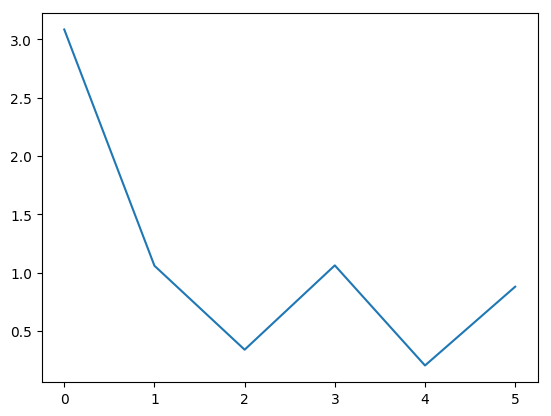

In [35]:
# 可视化 loss
log_loss = [loss_log.losses[i] for i in range(0, len(loss_log.losses), 10)]
plt.figure()
plt.plot(log_loss)

## 6. 模型评估

评估指标(Metric)用来衡量一个模型的效果, 一般是通过计算模型的预测结果和真实结果之间的某种差距。

使用Paddle高层API的Model.evaluate接口可以一键完成模型评估操作，结束后根据在Model.prepare中定义的loss和metric计算并返回相关评估结果。

In [36]:
model.load('lstm_checkpoint/final')
# 用 evaluate 在测试集上对模型进行验证
eval_result = model.evaluate(eval_dataset,batch_size=batch_size, verbose=1)
print(eval_result)

Eval begin...
step 4/4 [==============================] - loss: 0.3704 - acc: 0.5333 - 4ms/step
Eval samples: 30
{'loss': [0.37043995], 'acc': 0.5333333333333333}


## 7. 模型预测

对模型进行预测，展示效果。高层API中提供了Model.predict接口，可对训练好的模型进行推理验证。只需传入待执行推理验证的样本数据，即可计算并返回推理结果。

In [37]:
model.load('lstm_checkpoint/final')
test_result = model.predict(eval_dataset)
# 由于模型是单一输出，test_result的形状为[1, N]，N是测试数据集的数据量。这里打印第一个数据的预测结果。
print(len(test_result))
print(test_result[0][0])
print('预测值:{0}, 实际值:{1}'.format(test_result[0][0][0],eval_dataset[0][1][0]))

Predict begin...
step 30/30 [==============================] - 2ms/step          
Predict samples: 30
1
[[0.7306909]]
预测值:[0.7306909], 实际值:Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [1.])
